# Machine Learning Trading Bot

In this Challenge, you’ll assume the role of a financial advisor at one of the top five financial advisory firms in the world. Your firm constantly competes with the other major firms to manage and automatically trade assets in a highly dynamic environment. In recent years, your firm has heavily profited by using computer algorithms that can buy and sell faster than human traders.

The speed of these transactions gave your firm a competitive advantage early on. But, people still need to specifically program these systems, which limits their ability to adapt to new data. You’re thus planning to improve the existing algorithmic trading systems and maintain the firm’s competitive advantage in the market. To do so, you’ll enhance the existing trading signals with machine learning algorithms that can adapt to new data.

## Instructions:

Use the starter code file to complete the steps that the instructions outline. The steps for this Challenge are divided into the following sections:

* Establish a Baseline Performance

* Tune the Baseline Trading Algorithm

* Evaluate a New Machine Learning Classifier

* Create an Evaluation Report

#### Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 

1. Import the OHLCV dataset into a Pandas DataFrame.

2. Generate trading signals using short- and long-window SMA values. 

3. Split the data into training and testing datasets.

4. Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

5. Review the classification report associated with the `SVC` model predictions. 

6. Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

7. Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

8. Write your conclusions about the performance of the baseline trading algorithm in the `README.md` file that’s associated with your GitHub repository. Support your findings by using the PNG image that you saved in the previous step.

#### Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (You’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing the training window?

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

#### Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. To do so, complete the following steps:

1. Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

2. Using the original training data as the baseline model, fit another model with the new classifier.

3. Backtest the new model to evaluate its performance. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. Answer the following questions: Did this new model perform better or worse than the provided baseline model? Did this new model perform better or worse than your tuned trading algorithm?

#### Create an Evaluation Report

In the previous sections, you updated your `README.md` file with your conclusions. To accomplish this section, you need to add a summary evaluation report at the end of the `README.md` file. For this report, express your final conclusions and analysis. Support your findings by using the PNG images that you created.


In [34]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

---

## Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: mport the OHLCV dataset into a Pandas DataFrame.

In [35]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [36]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [37]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [38]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [39]:
signals_df['Signal'].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [40]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<AxesSubplot:xlabel='date'>

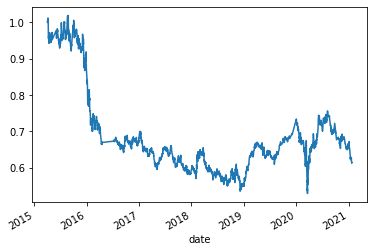

In [41]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [42]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
display(X.head())
display(X.tail())

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


,SMA_Fast,SMA_Slow
date,,
2021-01-22 09:30:00,33.1725,30.36035
2021-01-22 11:30:00,33.2025,30.40215
2021-01-22 13:45:00,33.2725,30.44445
2021-01-22 14:30:00,33.3850,30.48745
2021-01-22 15:45:00,33.3775,30.53085


In [43]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [44]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [165]:
# Select the ending period for the training data with an offset of 3 months
months=3
training_end = X.index.min() + DateOffset(months=months)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [46]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [47]:
# Generate the X_test and y_test DataFrames
# my op: 7/2/2015 15:45 and then 7/6/2015 10:00; no 7/2/2015 16:00 in between
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.head())
display(X_test.tail())

,SMA_Fast,SMA_Slow
date,,
2015-07-06 10:00:00,24.1250,25.0919
2015-07-06 10:45:00,23.9700,25.0682
2015-07-06 14:15:00,23.8475,25.0458
2015-07-06 14:30:00,23.6725,25.0206
2015-07-07 11:30:00,23.4800,24.9951


,SMA_Fast,SMA_Slow
date,,
2021-01-22 09:30:00,33.1725,30.36035
2021-01-22 11:30:00,33.2025,30.40215
2021-01-22 13:45:00,33.2725,30.44445
2021-01-22 14:30:00,33.3850,30.48745
2021-01-22 15:45:00,33.3775,30.53085


In [48]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [49]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
# YOUR CODE HERE
svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [50]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report =  classification_report(y_test, svm_pred)

# Print the classification report
# YOUR CODE HERE
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1804
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4092
   macro avg       0.49      0.50      0.39      4092
weighted avg       0.50      0.55      0.43      4092



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [52]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df =  pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df["Actual Returns"] 


# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Actual Returns'] * predictions_df['Predicted']


# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

#### result

<AxesSubplot:title={'center':"actual returns vs. the strategy returns.\nSVM's features set contains SMA_fast( 4 days), and SMA_slow( 100 days).\nThe training data period is 3 months."}, xlabel='date'>

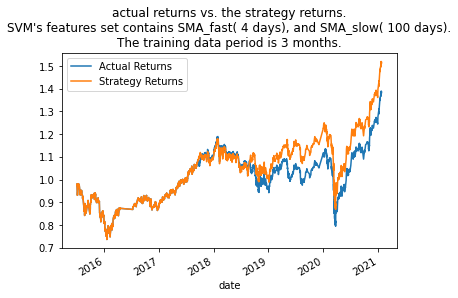

In [183]:
# Plot the actual returns versus the strategy returns
# YOUR CODE HERE
first_name = "abc"
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
title =
f"actual returns vs. the strategy returns."
+f"\nSVM's features set contains SMA_fast( {short_window} days), and SMA_slow( {long_window} days)."
+f"\nThe training data period is {months} months."
)

---

## Tune the Baseline Trading Algorithm

## Step 6: Use an Alternative ML Model and Evaluate Strategy Returns

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing the training window?

**Answer**: If the training window is less than six month, increasing the training window would imrove Strategy Returns' performance; however, if the training window is greater than six month, increasing it would lower the performance instead.

#### Select the ending period for the training data with an offset of 8 months

In [55]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X_2
X_2 = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
display(X_2.head())
display(X_2.tail())
#--

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


,SMA_Fast,SMA_Slow
date,,
2021-01-22 09:30:00,33.1725,30.36035
2021-01-22 11:30:00,33.2025,30.40215
2021-01-22 13:45:00,33.2725,30.44445
2021-01-22 14:30:00,33.3850,30.48745
2021-01-22 15:45:00,33.3775,30.53085


In [56]:
# Create the target set selecting the Signal column and assiging it to y_2
y_2 = signals_df['Signal']

# Review the value counts
y_2.value_counts()
#--
# Select the start of the training period
training_begin_2 = X_2.index.min()

# Display the training begin date
print(training_begin_2)
#--

2015-04-02 15:00:00


In [168]:
# Select the ending period for the training data with an offset of 8 months
months_2 = 8
training_end_2 = X_2.index.min() + DateOffset(months=months_2)

# Display the training end date
print(training_end_2)
#--

2015-12-02 15:00:00


In [122]:
# Generate the X_train_2 and y_train_2 DataFrames
X_train_2 = X_2.loc[training_begin_2:training_end_2]
y_train_2 = y_2.loc[training_begin_2:training_end_2]

# Review the X_train_2 DataFrame
X_train_2.head()
#--

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [123]:
# Generate the X_test_2 and y_test_2 DataFrames
X_test_2 = X_2.loc[training_end_2+DateOffset(hours=1):]
y_test_2 = y_2.loc[training_end_2+DateOffset(hours=1):]

# Review the X_test_2 DataFrame
display(X_test_2.head())
display(X_test_2.tail())
#--

,SMA_Fast,SMA_Slow
date,,
2015-12-03 10:30:00,21.7675,22.13761
2015-12-03 10:45:00,21.5175,22.12251
2015-12-03 11:00:00,21.2775,22.10601
2015-12-03 11:15:00,21.0275,22.08961
2015-12-03 13:30:00,20.7900,22.07301


,SMA_Fast,SMA_Slow
date,,
2021-01-22 09:30:00,33.1725,30.36035
2021-01-22 11:30:00,33.2025,30.40215
2021-01-22 13:45:00,33.2725,30.44445
2021-01-22 14:30:00,33.3850,30.48745
2021-01-22 15:45:00,33.3775,30.53085


In [124]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler_2 = StandardScaler()

# Apply the scaler_2 model to fit the X_2-train data
X_scaler_2 = scaler_2.fit(X_train_2)

# Transform the X_train_2 and X_test_2 DataFrames using the X_scaler_2
X_train_scaled_2 = X_scaler_2.transform(X_train_2)
X_test_scaled_2 = X_scaler_2.transform(X_test_2)
#--

In [125]:
# From SVM, instantiate SVC classifier model instance
svm_model_2 = svm.SVC()
 
# Fit the model to the data using the training data
svm_model_2 = svm_model_2.fit(X_train_scaled_2, y_train_2)
 
# Use the testing data to make the model predictions
svm_pred_2 = svm_model_2.predict(X_test_scaled_2)

# Review the model's predicted values
# YOUR CODE HERE
svm_pred_2[:10]
#--

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [126]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report_2 =  classification_report(y_test_2, svm_pred_2)

# Print the classification report
# YOUR CODE HERE
print(svm_testing_report_2)
#--

              precision    recall  f1-score   support

        -1.0       0.43      0.16      0.24      1670
         1.0       0.56      0.83      0.67      2142

    accuracy                           0.54      3812
   macro avg       0.50      0.50      0.45      3812
weighted avg       0.50      0.54      0.48      3812



In [127]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df_2 =  pd.DataFrame(index=X_test_2.index)

# Add the SVM model predictions to the DataFrame
predictions_df_2['Predicted'] = svm_pred_2

# Add the actual returns to the DataFrame
predictions_df_2['Actual Returns'] = signals_df["Actual Returns"] 


# Add the strategy returns to the DataFrame
predictions_df_2['Strategy Returns'] = signals_df['Actual Returns'] * predictions_df_2['Predicted']


# Review the DataFrame
display(predictions_df_2.head())
display(predictions_df_2.tail())
#--

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-12-03 10:30:00,1.0,-0.045935,-0.045935
2015-12-03 10:45:00,1.0,0.000481,0.000481
2015-12-03 11:00:00,1.0,0.000481,0.000481
2015-12-03 11:15:00,1.0,0.001443,0.001443
2015-12-03 13:30:00,1.0,-0.006244,-0.006244


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


#### Step 1 result

<AxesSubplot:title={'center':"actual returns vs. the strategy returns.\nSVM's features set contains SMA_fast( 4 days), and SMA_slow( 100 days).\nThe training data period is 8 months."}, xlabel='date'>

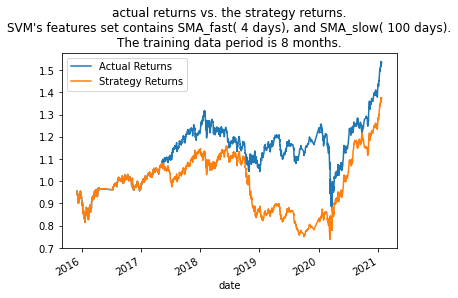

In [184]:
# Plot the actual returns versus the strategy returns
# YOUR CODE HERE
(1 + predictions_df_2[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
title = 
f"actual returns vs. the strategy returns."
+f"\nSVM's features set contains SMA_fast( {short_window} days), and SMA_slow( {long_window} days)."
+f"\nThe training data period is {months_2} months."

)

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

#### set the fast simple moving averages (32 dayS)

In [84]:
# Set the short window and
short_window_3 = 32

# Generate the slow simple moving averages (32 dayS)
signals_df['SMA_Fast_3'] = signals_df['close'].rolling(window=short_window_3).mean()
#--

In [85]:
# Assign a copy of the sma_fast_3 and sma_slow columns to a features DataFrame called X_3
X_3 = signals_df[['SMA_Fast_3', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
display(X_3.head())
display(X_3.tail())
#--

,SMA_Fast_3,SMA_Slow
date,,
2015-04-10 13:15:00,25.478750,24.7502
2015-04-10 13:30:00,25.509375,24.7693
2015-04-10 15:45:00,25.541562,24.7890
2015-04-13 09:30:00,25.571250,24.8077
2015-04-13 11:00:00,25.609375,24.8292


,SMA_Fast_3,SMA_Slow
date,,
2021-01-22 09:30:00,31.650000,30.36035
2021-01-22 11:30:00,31.749375,30.40215
2021-01-22 13:45:00,31.854062,30.44445
2021-01-22 14:30:00,31.951094,30.48745
2021-01-22 15:45:00,32.049844,30.53085


In [86]:
# Create the target set selecting the Signal column and assiging it to y_3
y_3 = signals_df['Signal']

# Review the value counts
y_3.value_counts()
#--

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [87]:
# Select the start of the training period
training_begin_3 = X_3.index.min()

# Display the training begin date
print(training_begin_3)
#--

2015-04-10 13:15:00


In [172]:
# Select the ending period for the training data with an offset of 3 months
months_3 = 3
training_end_3 = X_3.index.min() + DateOffset(months=months_3)

# Display the training end date
print(training_end_3)
#--

2015-07-10 13:15:00


In [89]:
# Generate the X_train_3 and y_train_3 DataFrames
X_train_3 = X_3.loc[training_begin_3:training_end_3]
y_train_3 = y_3.loc[training_begin_3:training_end_3]

# Review the X_train_3 DataFrame
X_train_3.head()
#--

,SMA_Fast_3,SMA_Slow
date,,
2015-04-10 13:15:00,25.478750,24.7502
2015-04-10 13:30:00,25.509375,24.7693
2015-04-10 15:45:00,25.541562,24.7890
2015-04-13 09:30:00,25.571250,24.8077
2015-04-13 11:00:00,25.609375,24.8292


In [90]:
# Generate the X_test_3 and y_test_3 DataFrames
# my op: 7/2/2015 15:45 and then 7/6/2015 10:00; no 7/2/2015 16:00 in between
X_test_3 = X_3.loc[training_end_3+DateOffset(hours=1):]
y_test_3 = y_3.loc[training_end_3+DateOffset(hours=1):]

# Review the X_test_3 DataFrame
display(X_test_3.head())
display(X_test_3.tail())
#--

,SMA_Fast_3,SMA_Slow
date,,
2015-07-14 09:45:00,23.653125,24.6397
2015-07-14 10:00:00,23.618125,24.6157
2015-07-14 10:45:00,23.581875,24.5909
2015-07-14 11:15:00,23.550937,24.5654
2015-07-14 11:30:00,23.519687,24.5405


,SMA_Fast_3,SMA_Slow
date,,
2021-01-22 09:30:00,31.650000,30.36035
2021-01-22 11:30:00,31.749375,30.40215
2021-01-22 13:45:00,31.854062,30.44445
2021-01-22 14:30:00,31.951094,30.48745
2021-01-22 15:45:00,32.049844,30.53085


In [91]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler_3 = StandardScaler()

# Apply the scaler_3 model to fit the X_3-train data
X_scaler = scaler_3.fit(X_train_3)

# Transform the X_train_3 and X_test_3 DataFrames using the X_scaler
X_train_scaled_3 = X_scaler.transform(X_train_3)
X_test_scaled_3 = X_scaler.transform(X_test_3)
#--

In [92]:
# From SVM, instantiate SVC classifier model instance
svm_model_3 = svm.SVC()
 
# Fit the model to the data using the training data
svm_model_3 = svm_model_3.fit(X_train_scaled_3, y_train_3)
 
# Use the testing data to make the model predictions
svm_pred_3 = svm_model_3.predict(X_test_scaled_3)

# Review the model's predicted values
# YOUR CODE HERE
svm_pred_3[:10]
#--

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [93]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report_3 =  classification_report(y_test_3, svm_pred_3)

# Print the classification report
# YOUR CODE HERE
print(svm_testing_report_3)
#--

              precision    recall  f1-score   support

        -1.0       0.43      0.05      0.09      1793
         1.0       0.56      0.95      0.70      2284

    accuracy                           0.55      4077
   macro avg       0.50      0.50      0.40      4077
weighted avg       0.50      0.55      0.43      4077



In [94]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df_3 =  pd.DataFrame(index=X_test_3.index)

# Add the SVM model predictions to the DataFrame
predictions_df_3['Predicted'] = svm_pred_3

# Add the actual returns to the DataFrame
predictions_df_3['Actual Returns'] = signals_df["Actual Returns"] 


# Add the strategy returns to the DataFrame
predictions_df_3['Strategy Returns'] = signals_df['Actual Returns'] * predictions_df_3['Predicted']


# Review the DataFrame
display(predictions_df_3.head())
display(predictions_df_3.tail())
#--

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-14 09:45:00,-1.0,0.046366,-0.046366
2015-07-14 10:00:00,-1.0,-0.000852,0.000852
2015-07-14 10:45:00,-1.0,0.000853,-0.000853
2015-07-14 11:15:00,-1.0,0.002556,-0.002556
2015-07-14 11:30:00,-1.0,0.000425,-0.000425


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


#### Step 2 result

<AxesSubplot:title={'center':"actual returns vs. the strategy returns.\nSVM's features set contains SMA_fast( 32 days), and SMA_slow( 100 days).\nThe training data period is 3 months."}, xlabel='date'>

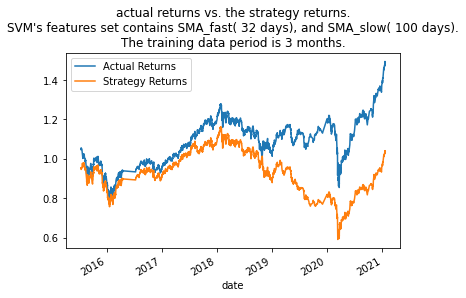

In [185]:
# Plot the actual returns versus the strategy returns
# YOUR CODE HERE
(1 + predictions_df_3[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
title = 
    
f"actual returns vs. the strategy returns."
+f"\nSVM's features set contains SMA_fast( {short_window_3} days), and SMA_slow( {long_window} days)."
+f"\nThe training data period is {months_3} months."

)

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

#### set the fast simple moving averages (4 days), and select the ending period for the training data with an offset of 6 months

In [137]:
# Set the short window
short_window_4 = 4

# Generate the slow simple moving averages (32 dayS)
signals_df['SMA_Fast_4'] = signals_df['close'].rolling(window=short_window_4).mean()
#--

In [137]:
# Assign a copy of the sma_fast_4 and sma_slow columns to a features DataFrame called X_4
X_4 = signals_df[['SMA_Fast_4', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
display(X_4.head())
display(X_4.tail())
#--

In [137]:
# Create the target set selecting the Signal column and assiging it to y_4
y_4 = signals_df['Signal']

# Review the value counts
y_4.value_counts()
#--

In [137]:
# Select the start of the training period
training_begin_4 = X_4.index.min()

# Display the training begin date
print(training_begin_4)
#--

,SMA_Fast_4,SMA_Slow
date,,
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463
2015-04-06 09:45:00,25.0075,24.3546
2015-04-06 10:15:00,25.0625,24.3634
2015-04-06 11:45:00,25.1200,24.3726


,SMA_Fast_4,SMA_Slow
date,,
2021-01-22 09:30:00,33.1725,30.36035
2021-01-22 11:30:00,33.2025,30.40215
2021-01-22 13:45:00,33.2725,30.44445
2021-01-22 14:30:00,33.3850,30.48745
2021-01-22 15:45:00,33.3775,30.53085


2015-04-02 15:45:00


In [174]:
# Select the ending period for the training data with an offset of 6 months
months_4 = 6
training_end_4 = X_4.index.min() + DateOffset(months=months_4)

# Display the training end date
print(training_end_4)
#--

2015-10-02 15:45:00


In [142]:
# Generate the X_train_4 and y_train_4 DataFrames
X_train_4 = X_4.loc[training_begin_4:training_end_4]
y_train_4 = y_4.loc[training_begin_4:training_end_4]

# Review the X_train_4 DataFrame
X_train_4.head()
#--

,SMA_Fast_4,SMA_Slow
date,,
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463
2015-04-06 09:45:00,25.0075,24.3546
2015-04-06 10:15:00,25.0625,24.3634
2015-04-06 11:45:00,25.1200,24.3726


In [143]:
# Generate the X_test_4 and y_test_4 DataFrames
# my op: 7/2/2015 15:45 and then 7/6/2015 10:00; no 7/2/2015 16:00 in between
X_test_4 = X_4.loc[training_end_4+DateOffset(hours=1):]
y_test_4 = y_4.loc[training_end_4+DateOffset(hours=1):]

# Review the X_test_4 DataFrame
display(X_test_4.head())
display(X_test_4.tail())
#--

,SMA_Fast_4,SMA_Slow
date,,
2015-10-05 09:45:00,21.42725,21.56409
2015-10-05 11:30:00,21.53225,21.55469
2015-10-05 13:15:00,21.60250,21.54289
2015-10-05 14:30:00,21.66750,21.53089
2015-10-05 14:45:00,21.75250,21.51939


,SMA_Fast_4,SMA_Slow
date,,
2021-01-22 09:30:00,33.1725,30.36035
2021-01-22 11:30:00,33.2025,30.40215
2021-01-22 13:45:00,33.2725,30.44445
2021-01-22 14:30:00,33.3850,30.48745
2021-01-22 15:45:00,33.3775,30.53085


In [144]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler_4 = StandardScaler()

# Apply the scaler_4 model to fit the X_4-train data
X_scaler = scaler_4.fit(X_train_4)

# Transform the X_train_4 and X_test_4 DataFrames using the X_scaler
X_train_scaled_4 = X_scaler.transform(X_train_4)
X_test_scaled_4 = X_scaler.transform(X_test_4)
#--

In [145]:
# From SVM, instantiate SVC classifier model instance
svm_model_4 = svm.SVC()
 
# Fit the model to the data using the training data
svm_model_4 = svm_model_4.fit(X_train_scaled_4, y_train_4)
 
# Use the testing data to make the model predictions
svm_pred_4 = svm_model_4.predict(X_test_scaled_4)

# Review the model's predicted values
# YOUR CODE HERE
svm_pred_4[:10]
#--

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [139]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report_4 =  classification_report(y_test_4, svm_pred_4)

# Print the classification report
# YOUR CODE HERE
print(svm_testing_report_4)
#--

              precision    recall  f1-score   support

        -1.0       0.44      0.04      0.07      1732
         1.0       0.56      0.96      0.71      2211

    accuracy                           0.56      3943
   macro avg       0.50      0.50      0.39      3943
weighted avg       0.51      0.56      0.43      3943



In [146]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df_4 =  pd.DataFrame(index=X_test_4.index)

# Add the SVM model predictions to the DataFrame
predictions_df_4['Predicted'] = svm_pred_4

# Add the actual returns to the DataFrame
predictions_df_4['Actual Returns'] = signals_df["Actual Returns"] 


# Add the strategy returns to the DataFrame
predictions_df_4['Strategy Returns'] = signals_df['Actual Returns'] * predictions_df_4['Predicted']


# Review the DataFrame
display(predictions_df_4.head())
display(predictions_df_4.tail())
#--

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-10-05 09:45:00,1.0,0.013532,0.013532
2015-10-05 11:30:00,1.0,0.002302,0.002302
2015-10-05 13:15:00,1.0,-0.000919,-0.000919
2015-10-05 14:30:00,1.0,0.000920,0.000920
2015-10-05 14:45:00,1.0,0.002756,0.002756


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


#### Step 3 result:

<AxesSubplot:title={'center':"actual returns vs. the strategy returns.\nSVM's features set contains SMA_fast( 4 days), and SMA_slow( 100 days).\nThe training data period is 6 months."}, xlabel='date'>

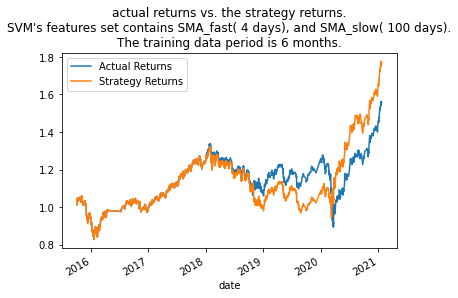

In [186]:
# Plot the actual returns versus the strategy returns
# YOUR CODE HERE
(1 + predictions_df_4[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
title = 

f"actual returns vs. the strategy returns."
+f"\nSVM's features set contains SMA_fast( {short_window_4} days), and SMA_slow( {long_window} days)."
+f"\nThe training data period is {months_4} months."

)

---

## Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [130]:
# Import a new classifier from SKLearn
# YOUR CODE HERE
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
# YOUR CODE HERE
logistic_regression_model = LogisticRegression()

### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [131]:
# Fit the model using the training data
model = logistic_regression_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = logistic_regression_model.predict(X_test_scaled)

# Review the model's predicted values
# YOUR CODE HERE
pred

array([ 1.,  1.,  1., ..., -1., -1., -1.])

### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

In [148]:
# Use a classification report to evaluate the model using the predictions and testing data
# YOUR CODE HERE
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Print the classification report
# YOUR CODE HERE
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.33      0.38      1804
         1.0       0.56      0.66      0.61      2288

    accuracy                           0.52      4092
   macro avg       0.50      0.50      0.49      4092
weighted avg       0.51      0.52      0.51      4092



In [149]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
lr_predictions_df =  pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
# YOUR CODE HERE
lr_predictions_df['Predicted'] = pred

# Add the actual returns to the DataFrame
# YOUR CODE HERE
lr_predictions_df['Actual Returns'] = signals_df["Actual Returns"] 

# Add the strategy returns to the DataFrame
# YOUR CODE HERE
lr_predictions_df['Strategy Returns'] = signals_df['Strategy Returns'] * lr_predictions_df['Predicted']

# Review the DataFrame
# YOUR CODE HERE
display(lr_predictions_df.head())
display(lr_predictions_df.tail())


,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,0.025715
2015-07-06 10:45:00,1.0,0.007237,-0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,0.003841
2015-07-07 11:30:00,1.0,-0.018423,0.018423


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,-1.0,-0.006866,0.006866
2021-01-22 11:30:00,-1.0,0.002405,0.002405
2021-01-22 13:45:00,-1.0,0.002099,-0.002099
2021-01-22 14:30:00,-1.0,0.001496,-0.001496
2021-01-22 15:45:00,-1.0,-0.000896,0.000896


#### alternative maching learning classifier result

<AxesSubplot:title={'center':"actual returns vs. the strategy returns.\nLogistic Regression's features set contains SMA_fast( 4 days), and SMA_slow( 100 days).\nThe training data period is 3 months."}, xlabel='date'>

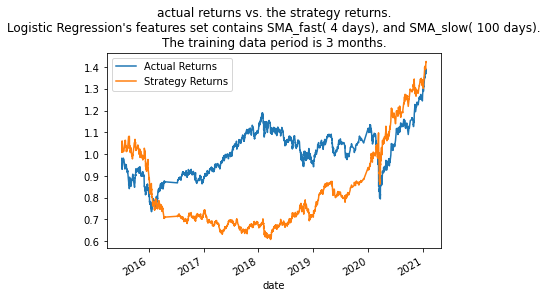

In [188]:
# Plot the actual returns versus the strategy returns
# YOUR CODE HERE
(1 + lr_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(
title = 
f"actual returns vs. the strategy returns."
+f"\nLogistic Regression's features set contains SMA_fast( {short_window} days), and SMA_slow( {long_window} days)."
+f"\nThe training data period is {months} months."
)